# Hyperparameter Optimization with CRPS and Train/Test Validation

This notebook demonstrates optimizing MMM hyperparameters using Optuna with **CRPS (Continuous Ranked Probability Score)** on a train/test split:
- **Training set**: First 80 weeks (weeks 1-80)
- **Test set**: Last 24 weeks (weeks 81-104)
- **Hyperparameters**: `yearly_seasonality` (1-10) and `adstock_max_lag` (4-12 weeks)

## Why CRPS?

Unlike WAIC (which evaluates in-sample fit), CRPS evaluates out-of-sample predictive performance:
- **WAIC**: Measures model fit on training data (penalized for complexity)
- **CRPS**: Measures prediction accuracy on held-out test data
- **Advantage**: Direct assessment of generalization performance

CRPS is a proper scoring rule that evaluates the entire predictive distribution, not just point estimates. Lower CRPS = better predictions.

## Optimization Strategy

1. **Train/test split**: 80 weeks train, 24 weeks test (no data leakage)
2. **Sequential trials** (no parallel optimization)
3. **NumPyro sampler** for 2-10x speedup
4. **Convergence checks** on training set
5. **CRPS evaluation** on test set using posterior predictive
6. **Reduced MCMC** during optimization (500 draws/tune)
7. **Final refit** on full data with optimal parameters (2000 draws/tune)
8. **Optuna pruning** for failed convergence

## Implementation Notes

- `pymc_marketing.metrics.crps()` expects `y_pred` with shape (n_samples, n_observations)
- Posterior predictive samples provide the probabilistic predictions
- NumPyro progress bar disabled in Jupyter to avoid kernel issues

## Setup

In [18]:
from pathlib import Path
from typing import Any

import optuna
import pandas as pd
import polars as pl
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.metrics import crps
from rich import print as rprint
from rich.console import Console
from rich.table import Table

## Configuration

In [19]:
# Train/test split
TEST_SIZE_WEEKS = 24  # Last 24 weeks for testing

# Optimization settings
N_TRIALS = 20
OPTUNA_DRAWS = 500
OPTUNA_TUNE = 500
OPTUNA_CHAINS = 2

# Final model settings
FINAL_DRAWS = 2000
FINAL_TUNE = 2000
FINAL_CHAINS = 4

# Sampler selection
USE_NUMPYRO = True
NUTS_SAMPLER = "numpyro" if USE_NUMPYRO else "pymc"

# Convergence thresholds for optimization (lenient)
OPTUNA_DIVERGENCE_THRESHOLD = 0.10
OPTUNA_RHAT_THRESHOLD = 1.10
OPTUNA_ESS_THRESHOLD = 50

# Convergence thresholds for final model (strict)
FINAL_DIVERGENCE_THRESHOLD = 0.01
FINAL_RHAT_THRESHOLD = 1.01
FINAL_ESS_THRESHOLD = 400

# Random seed
RANDOM_SEED = 42

rprint(f"[bold blue]Configuration:[/bold blue]")
rprint(f"Train/test split: {TEST_SIZE_WEEKS} weeks for test")
rprint(f"Number of trials: {N_TRIALS}")
rprint(f"NUTS sampler: [yellow]{NUTS_SAMPLER}[/yellow] {'(NumPyro - faster!)' if USE_NUMPYRO else '(PyMC default)'}")
rprint(f"Optimization MCMC: {OPTUNA_DRAWS} draws, {OPTUNA_TUNE} tune, {OPTUNA_CHAINS} chains")
rprint(f"Final model MCMC: {FINAL_DRAWS} draws, {FINAL_TUNE} tune, {FINAL_CHAINS} chains")
rprint(f"\n[bold yellow]Convergence Thresholds:[/bold yellow]")
rprint(f"Optimization - Divergences: <{OPTUNA_DIVERGENCE_THRESHOLD*100:.0f}%, R-hat: <{OPTUNA_RHAT_THRESHOLD}, ESS: >{OPTUNA_ESS_THRESHOLD}")
rprint(f"Final model  - Divergences: <{FINAL_DIVERGENCE_THRESHOLD*100:.0f}%, R-hat: <{FINAL_RHAT_THRESHOLD}, ESS: >{FINAL_ESS_THRESHOLD}")

Configuration:

Train/test split: 24 weeks for test

Number of trials: 20

NUTS sampler: numpyro (NumPyro - faster!)

Optimization MCMC: 500 draws, 500 tune, 2 chains

Final model MCMC: 2000 draws, 2000 tune, 4 chains

Convergence Thresholds:

Optimization - Divergences: <10%, R-hat: <1.1, ESS: >50

Final model  - Divergences: <1%, R-hat: <1.01, ESS: >400

## Load Data

In [ ]:
def load_mmm_data(data_path: str | Path) -> pl.DataFrame:
    """Load MMM data from CSV file.
    
    Args:
        data_path: Path to the mmm_data.csv file
        
    Returns:
        Polars DataFrame with parsed date column
    """
    return pl.read_csv(data_path).with_columns(
        pl.col("date").str.to_date()
    )


# Load the data
data_path = Path("../data/mmm-simple/mmm_data.csv")
df = load_mmm_data(data_path)

rprint(f"[bold green]Data loaded successfully[/bold green]")
rprint(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
rprint(f"Date range: {df['date'].min()} to {df['date'].max()}")

## Train/Test Split

Split data chronologically: first 80 weeks for training, last 24 weeks for testing.

In [21]:
def split_train_test(
    df: pl.DataFrame,
    test_size_weeks: int
) -> tuple[pl.DataFrame, pl.DataFrame]:
    """Split data into train and test sets chronologically.
    
    Args:
        df: Full dataset
        test_size_weeks: Number of weeks to use for test set
        
    Returns:
        Tuple of (train_df, test_df)
    """
    n_total = df.shape[0]
    n_train = n_total - test_size_weeks
    
    # Sort by date to ensure chronological order
    df_sorted = df.sort("date")
    
    train_df = df_sorted[:n_train]
    test_df = df_sorted[n_train:]
    
    return train_df, test_df


# Split data
df_train, df_test = split_train_test(df, TEST_SIZE_WEEKS)

rprint("\n[bold blue]Train/Test Split:[/bold blue]")
rprint(f"Train set: {df_train.shape[0]} weeks ({df_train['date'].min()} to {df_train['date'].max()})")
rprint(f"Test set:  {df_test.shape[0]} weeks ({df_test['date'].min()} to {df_test['date'].max()})")

# Convert to pandas for PyMC-Marketing
df_train_pandas = df_train.to_pandas()
df_test_pandas = df_test.to_pandas()

# Define model inputs
channel_columns = [
    "x1_Search-Ads",
    "x2_Social-Media",
    "x3_Local-Ads",
    "x4_Email"
]

control_columns = ["c1", "c2"]

# Prepare train/test splits
X_train = df_train_pandas.drop(columns=["y"])
y_train = df_train_pandas["y"]

X_test = df_test_pandas.drop(columns=["y"])
y_test = df_test_pandas["y"]

rprint("\n[bold blue]Model Configuration:[/bold blue]")
rprint(f"Target column: [yellow]y[/yellow]")
rprint(f"Date column: [yellow]date[/yellow]")
rprint(f"Channel columns: [yellow]{channel_columns}[/yellow]")
rprint(f"Control columns: [yellow]{control_columns}[/yellow]")

Train/Test Split:

Train set: 80 weeks (2020-01-05 to 2021-07-11)

Test set:  24 weeks (2021-07-18 to 2021-12-26)

Model Configuration:

Target column: y

Date column: date

Channel columns: ['x1_Search-Ads', 'x2_Social-Media', 'x3_Local-Ads', 'x4_Email']

Control columns: ['c1', 'c2']

## Convergence Diagnostics

Helper function to check MCMC convergence quality.

In [22]:
import arviz as az
import numpy as np
import warnings


def check_convergence(
    mmm: MMM,
    divergence_threshold: float,
    rhat_threshold: float,
    ess_threshold: float,
    trial_number: int | None = None
) -> tuple[bool, dict[str, float]]:
    """Check MCMC convergence diagnostics.
    
    Args:
        mmm: Fitted MMM model
        divergence_threshold: Maximum allowed divergence rate (0-1)
        rhat_threshold: Maximum allowed R-hat value
        ess_threshold: Minimum required effective sample size
        trial_number: Optional trial number for logging
        
    Returns:
        Tuple of (converged: bool, diagnostics: dict)
    """
    # 1. Check divergences
    n_divergences = int(mmm.idata.sample_stats.diverging.sum().item())
    n_draws = mmm.idata.posterior.sizes["draw"]
    n_chains = mmm.idata.posterior.sizes["chain"]
    total_samples = n_draws * n_chains
    divergence_rate = n_divergences / total_samples
    
    # 2. Check R-hat
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered.*")
        rhat = az.rhat(mmm.idata)
        max_rhat = float(rhat.to_array().max())
    
    # 3. Check ESS
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered.*")
        ess = az.ess(mmm.idata)
        min_ess = float(ess.to_array().min())
    
    # Convergence checks
    divergence_ok = divergence_rate <= divergence_threshold
    rhat_ok = max_rhat <= rhat_threshold
    ess_ok = min_ess >= ess_threshold
    
    converged = divergence_ok and rhat_ok and ess_ok
    
    # Diagnostics dictionary
    diagnostics = {
        "n_divergences": n_divergences,
        "divergence_rate": divergence_rate,
        "max_rhat": max_rhat,
        "min_ess": min_ess,
    }
    
    # Logging
    trial_str = f"Trial {trial_number}" if trial_number is not None else "Model"
    
    if converged:
        rprint(
            f"[green]✓ {trial_str} CONVERGED:[/green] "
            f"divergences={divergence_rate*100:.1f}%, "
            f"max_rhat={max_rhat:.3f}, "
            f"min_ess={min_ess:.0f}"
        )
    else:
        reasons = []
        if not divergence_ok:
            reasons.append(f"divergences={divergence_rate*100:.1f}% (>{divergence_threshold*100:.0f}%)")
        if not rhat_ok:
            reasons.append(f"max_rhat={max_rhat:.3f} (>{rhat_threshold})")
        if not ess_ok:
            reasons.append(f"min_ess={min_ess:.0f} (<{ess_threshold})")
        
        rprint(
            f"[red]✗ {trial_str} FAILED:[/red] "
            f"{', '.join(reasons)}"
        )
    
    return converged, diagnostics


rprint("[bold green]Convergence check function defined[/bold green]")

Convergence check function defined

## CRPS Evaluation Function

Compute CRPS on test set using posterior predictive samples.

In [23]:
def compute_test_crps(
    mmm: MMM,
    X_test: pd.DataFrame,
    y_test: pd.Series
) -> float:
    """Compute CRPS on test set using posterior predictive.
    
    Args:
        mmm: Fitted MMM model
        X_test: Test features
        y_test: Test target values
        
    Returns:
        CRPS score (lower is better)
    """
    # Sample posterior predictive for test set
    # Note: original_scale=True doesn't rescale posterior_predictive samples
    mmm.sample_posterior_predictive(
        X_test,
        original_scale=True,
        extend_idata=True
    )
    
    # Extract posterior predictive samples (in normalized scale)
    # Shape: (n_chains, n_draws, n_observations)
    y_pred_samples = mmm.idata.posterior_predictive["y"].values
    
    # Manually rescale to original scale
    target_scale = float(mmm.idata.constant_data["target_scale"].values)
    y_pred_rescaled = y_pred_samples * target_scale
    
    # Reshape to (n_samples, n_observations) as expected by crps()
    # n_samples = n_chains * n_draws
    n_chains, n_draws, n_obs = y_pred_rescaled.shape
    y_pred_reshaped = y_pred_rescaled.reshape(n_chains * n_draws, n_obs)
    
    # Compute CRPS
    y_test_array = y_test.values
    crps_score = crps(y_test_array, y_pred_reshaped)
    
    return float(crps_score)


rprint("[bold green]CRPS evaluation function defined[/bold green]")

CRPS evaluation function defined

## Define Optuna Objective Function

The objective function:
1. Suggests hyperparameters from search space
2. Creates and fits MMM model on **train set**
3. Checks convergence on train set
4. Computes CRPS on **test set** (lower is better)
5. Returns CRPS for Optuna to minimize

In [24]:
def create_objective(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    channel_columns: list[str],
    control_columns: list[str],
    draws: int,
    tune: int,
    chains: int,
    divergence_threshold: float,
    rhat_threshold: float,
    ess_threshold: float,
    nuts_sampler: str = "pymc"
) -> callable:
    """Create Optuna objective function using CRPS on test set.
    
    Args:
        X_train: Training features
        y_train: Training target
        X_test: Test features
        y_test: Test target
        channel_columns: List of channel column names
        control_columns: List of control column names
        draws: Number of MCMC draws
        tune: Number of tuning steps
        chains: Number of MCMC chains
        divergence_threshold: Maximum allowed divergence rate
        rhat_threshold: Maximum allowed R-hat value
        ess_threshold: Minimum required effective sample size
        nuts_sampler: NUTS sampler to use
        
    Returns:
        Objective function that takes Optuna trial and returns test CRPS
    """
    def objective(trial: optuna.Trial) -> float:
        """Optuna objective function using CRPS on test set.
        
        Args:
            trial: Optuna trial object
            
        Returns:
            Test CRPS value (lower is better)
            
        Raises:
            optuna.TrialPruned: If model fails to converge
        """
        # Suggest hyperparameters
        yearly_seasonality = trial.suggest_int("yearly_seasonality", 1, 10)
        adstock_max_lag = trial.suggest_int("adstock_max_lag", 4, 12)
        
        rprint(
            f"\n[bold cyan]Trial {trial.number}:[/bold cyan] "
            f"yearly_seasonality={yearly_seasonality}, "
            f"adstock_max_lag={adstock_max_lag}"
        )
        
        # Create MMM model
        mmm = MMM(
            date_column="date",
            channel_columns=channel_columns,
            control_columns=control_columns,
            adstock=GeometricAdstock(l_max=adstock_max_lag),
            saturation=LogisticSaturation(),
            yearly_seasonality=yearly_seasonality
        )
        
        # Fit model on TRAINING set
        mmm.fit(
            X=X_train,
            y=y_train,
            draws=draws,
            tune=tune,
            chains=chains,
            nuts_sampler=nuts_sampler,
            random_seed=RANDOM_SEED + trial.number,
            progressbar=False
        )
        
        # Check convergence
        converged, diagnostics = check_convergence(
            mmm=mmm,
            divergence_threshold=divergence_threshold,
            rhat_threshold=rhat_threshold,
            ess_threshold=ess_threshold,
            trial_number=trial.number
        )
        
        # Store diagnostics
        trial.set_user_attr("n_divergences", diagnostics["n_divergences"])
        trial.set_user_attr("divergence_rate", diagnostics["divergence_rate"])
        trial.set_user_attr("max_rhat", diagnostics["max_rhat"])
        trial.set_user_attr("min_ess", diagnostics["min_ess"])
        trial.set_user_attr("converged", converged)
        
        # Prune if not converged
        if not converged:
            rprint(f"[red]Trial {trial.number} pruned due to convergence failure[/red]")
            raise optuna.TrialPruned()
        
        # Compute CRPS on TEST set
        test_crps = compute_test_crps(mmm, X_test, y_test)
        
        rprint(f"[yellow]Test CRPS: {test_crps:.2f}[/yellow]")
        
        # Store CRPS
        trial.set_user_attr("test_crps", test_crps)
        
        return test_crps
    
    return objective


# Create objective function
objective = create_objective(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    channel_columns=channel_columns,
    control_columns=control_columns,
    draws=OPTUNA_DRAWS,
    tune=OPTUNA_TUNE,
    chains=OPTUNA_CHAINS,
    divergence_threshold=OPTUNA_DIVERGENCE_THRESHOLD,
    rhat_threshold=OPTUNA_RHAT_THRESHOLD,
    ess_threshold=OPTUNA_ESS_THRESHOLD,
    nuts_sampler=NUTS_SAMPLER
)

rprint("[bold green]Objective function created with CRPS evaluation[/bold green]")

Objective function created with CRPS evaluation

## Run Optuna Optimization

This will run multiple trials to find hyperparameters that minimize test CRPS.

**Note**: This may take 15-30 minutes depending on `N_TRIALS` and hardware.

In [25]:
def run_optimization(
    objective: callable,
    n_trials: int,
    study_name: str = "mmm_crps_optimization"
) -> optuna.Study:
    """Run Optuna hyperparameter optimization.
    
    Args:
        objective: Objective function to minimize
        n_trials: Number of optimization trials
        study_name: Name for the Optuna study
        
    Returns:
        Completed Optuna study object
    """
    rprint(f"\n[bold magenta]Starting CRPS-based optimization with {n_trials} trials...[/bold magenta]\n")
    
    # Create study
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",  # Minimize test CRPS
        sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=0
        )
    )
    
    # Run optimization
    study.optimize(
        objective,
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    rprint("\n[bold green]Optimization completed![/bold green]")
    
    return study


# Run optimization
study = run_optimization(
    objective=objective,
    n_trials=N_TRIALS
)

Starting CRPS-based optimization with 20 trials...

[I 2025-10-19 22:11:48,845] A new study created in memory with name: mmm_crps_optimization


  0%|          | 0/20 [00:00<?, ?it/s]

Trial 0: yearly_seasonality=4, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 0 CONVERGED: divergences=0.0%, max_rhat=1.023, min_ess=189

Sampling: [y]


Output()

Test CRPS: 302.02

[I 2025-10-19 22:12:09,028] Trial 0 finished with value: 302.0187490319047 and parameters: {'yearly_seasonality': 4, 'adstock_max_lag': 12}. Best is trial 0 with value: 302.0187490319047.


Trial 1: yearly_seasonality=8, adstock_max_lag=9

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 1 CONVERGED: divergences=0.0%, max_rhat=1.017, min_ess=316

Sampling: [y]


Output()

Test CRPS: 316.97

[I 2025-10-19 22:12:18,837] Trial 1 finished with value: 316.96967178887326 and parameters: {'yearly_seasonality': 8, 'adstock_max_lag': 9}. Best is trial 0 with value: 302.0187490319047.


Trial 2: yearly_seasonality=2, adstock_max_lag=5

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 2 CONVERGED: divergences=0.0%, max_rhat=1.025, min_ess=215

Sampling: [y]


Output()

Test CRPS: 307.19

[I 2025-10-19 22:12:31,692] Trial 2 finished with value: 307.19145657442226 and parameters: {'yearly_seasonality': 2, 'adstock_max_lag': 5}. Best is trial 0 with value: 302.0187490319047.


Trial 3: yearly_seasonality=1, adstock_max_lag=11

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 3 CONVERGED: divergences=0.0%, max_rhat=1.008, min_ess=244

Sampling: [y]


Output()

Test CRPS: 307.42

[I 2025-10-19 22:12:44,659] Trial 3 finished with value: 307.42073931232034 and parameters: {'yearly_seasonality': 1, 'adstock_max_lag': 11}. Best is trial 0 with value: 302.0187490319047.


Trial 4: yearly_seasonality=7, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 4 CONVERGED: divergences=0.0%, max_rhat=1.015, min_ess=224

Sampling: [y]


Output()

Test CRPS: 312.57

[I 2025-10-19 22:13:02,891] Trial 4 finished with value: 312.56612368858083 and parameters: {'yearly_seasonality': 7, 'adstock_max_lag': 10}. Best is trial 0 with value: 302.0187490319047.


Trial 5: yearly_seasonality=1, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 5 CONVERGED: divergences=0.0%, max_rhat=1.012, min_ess=293

Sampling: [y]


Output()

Test CRPS: 312.61

[I 2025-10-19 22:13:15,561] Trial 5 finished with value: 312.60564160075813 and parameters: {'yearly_seasonality': 1, 'adstock_max_lag': 12}. Best is trial 0 with value: 302.0187490319047.


Trial 6: yearly_seasonality=9, adstock_max_lag=5

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 6 CONVERGED: divergences=0.0%, max_rhat=1.012, min_ess=375

Sampling: [y]


Output()

Test CRPS: 350.53

[I 2025-10-19 22:13:33,525] Trial 6 finished with value: 350.53062597115076 and parameters: {'yearly_seasonality': 9, 'adstock_max_lag': 5}. Best is trial 0 with value: 302.0187490319047.


Trial 7: yearly_seasonality=2, adstock_max_lag=5

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 7 CONVERGED: divergences=0.0%, max_rhat=1.013, min_ess=285

Sampling: [y]


Output()

Test CRPS: 306.88

[I 2025-10-19 22:13:45,988] Trial 7 finished with value: 306.87572155405974 and parameters: {'yearly_seasonality': 2, 'adstock_max_lag': 5}. Best is trial 0 with value: 302.0187490319047.


Trial 8: yearly_seasonality=4, adstock_max_lag=8

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 8 CONVERGED: divergences=0.0%, max_rhat=1.009, min_ess=300

Sampling: [y]


Output()

Test CRPS: 306.39

[I 2025-10-19 22:13:58,828] Trial 8 finished with value: 306.3895098110311 and parameters: {'yearly_seasonality': 4, 'adstock_max_lag': 8}. Best is trial 0 with value: 302.0187490319047.


Trial 9: yearly_seasonality=5, adstock_max_lag=6

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 9 CONVERGED: divergences=0.0%, max_rhat=1.010, min_ess=228

Sampling: [y]


Output()

Test CRPS: 324.57

[I 2025-10-19 22:14:13,124] Trial 9 finished with value: 324.56684863873335 and parameters: {'yearly_seasonality': 5, 'adstock_max_lag': 6}. Best is trial 0 with value: 302.0187490319047.


Trial 10: yearly_seasonality=4, adstock_max_lag=8

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 10 CONVERGED: divergences=0.0%, max_rhat=1.014, min_ess=305

Sampling: [y]


Output()

Test CRPS: 308.12

[I 2025-10-19 22:14:24,240] Trial 10 finished with value: 308.116561154193 and parameters: {'yearly_seasonality': 4, 'adstock_max_lag': 8}. Best is trial 0 with value: 302.0187490319047.


Trial 11: yearly_seasonality=4, adstock_max_lag=8

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 11 CONVERGED: divergences=0.0%, max_rhat=1.033, min_ess=276

Sampling: [y]


Output()

Test CRPS: 304.68

[I 2025-10-19 22:14:37,147] Trial 11 finished with value: 304.684734924399 and parameters: {'yearly_seasonality': 4, 'adstock_max_lag': 8}. Best is trial 0 with value: 302.0187490319047.


Trial 12: yearly_seasonality=6, adstock_max_lag=7

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 12 CONVERGED: divergences=0.0%, max_rhat=1.022, min_ess=201

Sampling: [y]


Output()

Test CRPS: 312.71

[I 2025-10-19 22:14:49,603] Trial 12 finished with value: 312.7114175970824 and parameters: {'yearly_seasonality': 6, 'adstock_max_lag': 7}. Best is trial 0 with value: 302.0187490319047.


Trial 13: yearly_seasonality=3, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 13 CONVERGED: divergences=0.0%, max_rhat=1.023, min_ess=368

Sampling: [y]


Output()

Test CRPS: 294.71

[I 2025-10-19 22:15:02,920] Trial 13 finished with value: 294.7078719113994 and parameters: {'yearly_seasonality': 3, 'adstock_max_lag': 10}. Best is trial 13 with value: 294.7078719113994.


Trial 14: yearly_seasonality=3, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 14 CONVERGED: divergences=0.0%, max_rhat=1.008, min_ess=365

Sampling: [y]


Output()

Test CRPS: 299.80

[I 2025-10-19 22:15:16,343] Trial 14 finished with value: 299.79668627860553 and parameters: {'yearly_seasonality': 3, 'adstock_max_lag': 12}. Best is trial 13 with value: 294.7078719113994.


Trial 15: yearly_seasonality=3, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 15 CONVERGED: divergences=0.0%, max_rhat=1.013, min_ess=348

Sampling: [y]


Output()

Test CRPS: 304.75

[I 2025-10-19 22:15:28,702] Trial 15 finished with value: 304.7467904918494 and parameters: {'yearly_seasonality': 3, 'adstock_max_lag': 10}. Best is trial 13 with value: 294.7078719113994.


Trial 16: yearly_seasonality=6, adstock_max_lag=11

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 16 CONVERGED: divergences=0.0%, max_rhat=1.014, min_ess=275

Sampling: [y]


Output()

Test CRPS: 308.59

[I 2025-10-19 22:15:42,441] Trial 16 finished with value: 308.5894833925392 and parameters: {'yearly_seasonality': 6, 'adstock_max_lag': 11}. Best is trial 13 with value: 294.7078719113994.


Trial 17: yearly_seasonality=2, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 17 CONVERGED: divergences=0.0%, max_rhat=1.016, min_ess=401

Sampling: [y]


Output()

Test CRPS: 308.21

[I 2025-10-19 22:15:56,185] Trial 17 finished with value: 308.2065406864887 and parameters: {'yearly_seasonality': 2, 'adstock_max_lag': 10}. Best is trial 13 with value: 294.7078719113994.


Trial 18: yearly_seasonality=10, adstock_max_lag=11

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 18 CONVERGED: divergences=0.0%, max_rhat=1.024, min_ess=284

Sampling: [y]


Output()

Test CRPS: 348.04

[I 2025-10-19 22:16:08,941] Trial 18 finished with value: 348.04178969844725 and parameters: {'yearly_seasonality': 10, 'adstock_max_lag': 11}. Best is trial 13 with value: 294.7078719113994.


Trial 19: yearly_seasonality=3, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 19 CONVERGED: divergences=0.0%, max_rhat=1.017, min_ess=308

Sampling: [y]


Output()

Test CRPS: 301.46

[I 2025-10-19 22:16:21,827] Trial 19 finished with value: 301.4649398580174 and parameters: {'yearly_seasonality': 3, 'adstock_max_lag': 12}. Best is trial 13 with value: 294.7078719113994.


Optimization completed!

## Optimization Results

In [26]:
def display_optimization_results(study: optuna.Study) -> None:
    """Display optimization results in a Rich table.
    
    Args:
        study: Completed Optuna study
    """
    console = Console()
    
    # Best trial summary
    rprint("\n[bold magenta]Best Trial:[/bold magenta]")
    rprint(f"Trial number: [cyan]{study.best_trial.number}[/cyan]")
    rprint(f"Test CRPS: [yellow]{study.best_value:.2f}[/yellow]")
    rprint(f"Parameters:")
    for key, value in study.best_params.items():
        rprint(f"  - {key}: [green]{value}[/green]")
    
    # All trials table
    rprint("\n[bold blue]All Trials:[/bold blue]")
    table = Table(
        title="Optimization Trials (CRPS-based)",
        show_header=True,
        header_style="bold cyan"
    )
    
    table.add_column("Trial", justify="right")
    table.add_column("Yearly Seasonality", justify="right")
    table.add_column("Adstock Max Lag", justify="right")
    table.add_column("Test CRPS", justify="right")
    table.add_column("Status")
    
    for trial in study.trials:
        status_color = "green" if trial.state == optuna.trial.TrialState.COMPLETE else "red"
        crps_str = f"{trial.value:.2f}" if trial.value is not None else "N/A"
        
        table.add_row(
            str(trial.number),
            str(trial.params.get("yearly_seasonality", "N/A")),
            str(trial.params.get("adstock_max_lag", "N/A")),
            crps_str,
            f"[{status_color}]{trial.state.name}[/{status_color}]"
        )
    
    console.print(table)


display_optimization_results(study)

Best Trial:

Trial number: 13

Test CRPS: 294.71

Parameters:

- yearly_seasonality: 3

- adstock_max_lag: 10

All Trials:

                   Optimization Trials (CRPS-based)                    
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Trial ┃ Yearly Seasonality ┃ Adstock Max Lag ┃ Test CRPS ┃ Status   ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│     0 │                  4 │              12 │    302.02 │ COMPLETE │
│     1 │                  8 │               9 │    316.97 │ COMPLETE │
│     2 │                  2 │               5 │    307.19 │ COMPLETE │
│     3 │                  1 │              11 │    307.42 │ COMPLETE │
│     4 │                  7 │              10 │    312.57 │ COMPLETE │
│     5 │                  1 │              12 │    312.61 │ COMPLETE │
│     6 │                  9 │               5 │    350.53 │ COMPLETE │
│     7 │                  2 │               5 │    306.88 │ COMPLETE │
│     8 │                  4 │               8 │    306.39 │ COMPLETE │
│     9 │                  5 │               6 │    324.57 │ COMPLETE │
│    10 │                  4 │               8 │    308.12 │ COMPLETE │
│    11 │                  4 │               8 │    304.68 │ COMPLETE │
│    12 │                  6 │               7 │    312.71 │ COMPLETE │
│    13 │                  3 │              10 │    294.71 │ COMPLETE │
│    14 │                  3 │              12 │    299.80 │ COMPLETE │
│    15 │                  3 │              10 │    304.75 │ COMPLETE │
│    16 │                  6 │              11 │    308.59 │ COMPLETE │
│    17 │                  2 │              10 │    308.21 │ COMPLETE │
│    18 │                 10 │              11 │    348.04 │ COMPLETE │
│    19 │                  3 │              12 │    301.46 │ COMPLETE │
└───────┴────────────────────┴─────────────────┴───────────┴──────────┘

## Optimization History Visualization

/var/folders/90/l3_2bhf525jc3pk0d2dkc5_r0000gn/T/ipykernel_34154/1708015603.py:19: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
/var/folders/90/l3_2bhf525jc3pk0d2dkc5_r0000gn/T/ipykernel_34154/1708015603.py:24: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/var/folders/90/l3_2bhf525jc3pk0d2dkc5_r0000gn/T/ipykernel_34154/1708015603.py:29: ExperimentalWarning: optuna.visualization.matplotlib._contour.plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study, params=["yearly_seasonality", "adstock_max_lag"])


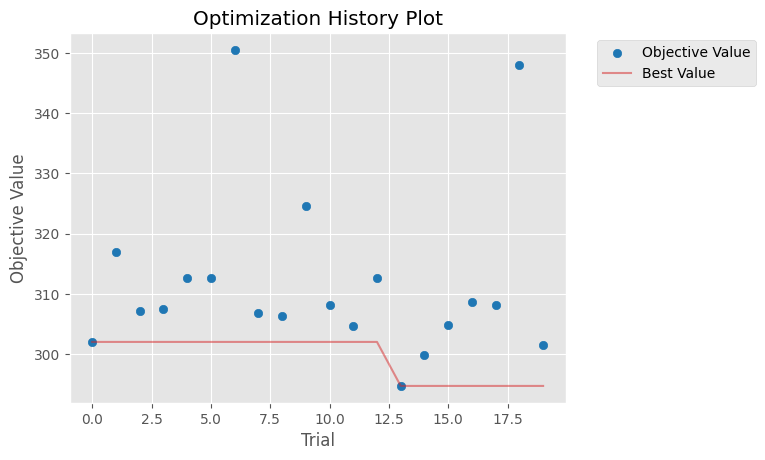

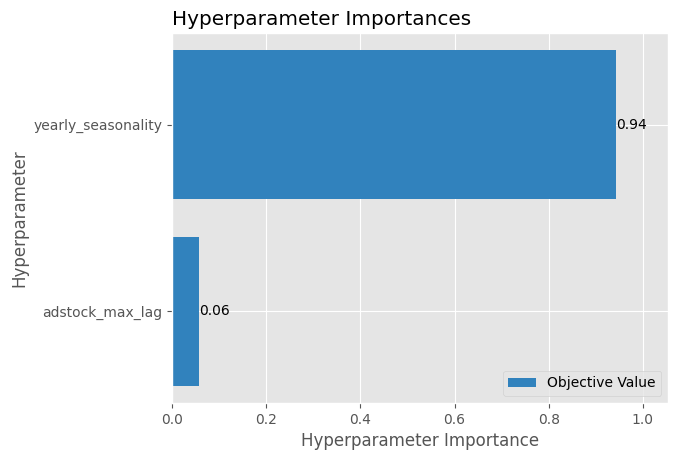

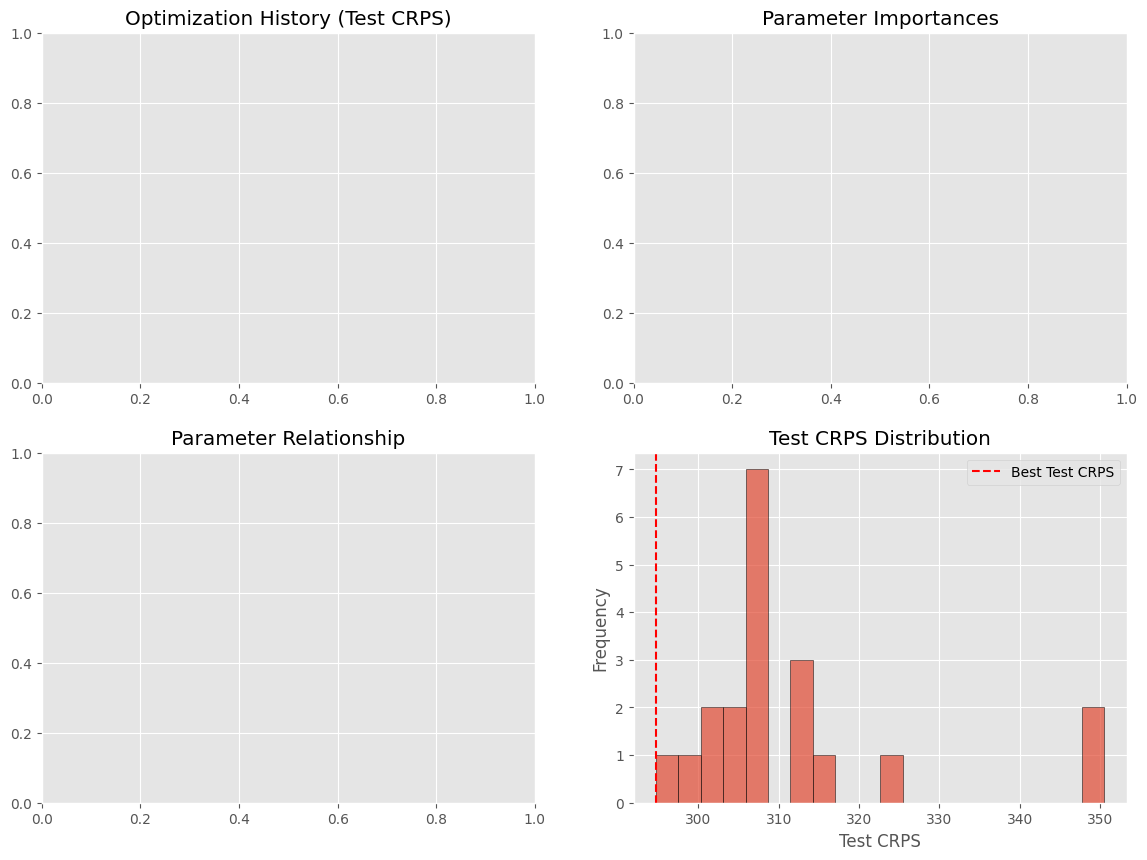

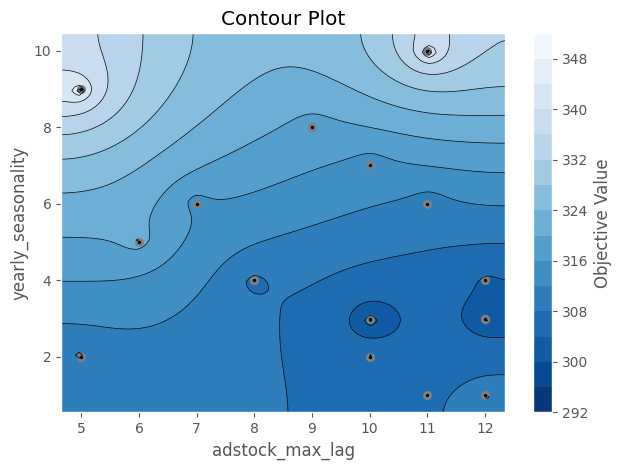

In [27]:
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_contour
)


def plot_optimization_results(study: optuna.Study) -> None:
    """Plot optimization results.
    
    Args:
        study: Completed Optuna study
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Optimization history
    plt.sca(axes[0, 0])
    plot_optimization_history(study)
    axes[0, 0].set_title("Optimization History (Test CRPS)")
    
    # Parameter importances
    plt.sca(axes[0, 1])
    plot_param_importances(study)
    axes[0, 1].set_title("Parameter Importances")
    
    # Contour plot
    plt.sca(axes[1, 0])
    plot_contour(study, params=["yearly_seasonality", "adstock_max_lag"])
    axes[1, 0].set_title("Parameter Relationship")
    
    # CRPS distribution
    crps_values = [t.value for t in study.trials if t.value is not None]
    axes[1, 1].hist(crps_values, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(study.best_value, color='red', linestyle='--', label='Best Test CRPS')
    axes[1, 1].set_xlabel('Test CRPS')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Test CRPS Distribution')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


plot_optimization_results(study)

## Fit Final Model on Full Dataset

Now refit the model with optimal parameters on the **full dataset** (all 104 weeks) using production-quality MCMC settings.

**Note**: Progress bar disabled for NumPyro to avoid Jupyter kernel issues.

In [28]:
def fit_final_model(
    X: pd.DataFrame,
    y: pd.Series,
    channel_columns: list[str],
    control_columns: list[str],
    best_params: dict[str, Any],
    draws: int,
    tune: int,
    chains: int,
    random_seed: int,
    divergence_threshold: float,
    rhat_threshold: float,
    ess_threshold: float,
    nuts_sampler: str = "pymc"
) -> MMM:
    """Fit final MMM model on full dataset with optimal hyperparameters.
    
    Args:
        X: Full dataset features
        y: Full dataset target
        channel_columns: List of channel column names
        control_columns: List of control column names
        best_params: Dictionary of optimal hyperparameters
        draws: Number of MCMC draws
        tune: Number of tuning steps
        chains: Number of MCMC chains
        random_seed: Random seed for reproducibility
        divergence_threshold: Maximum allowed divergence rate
        rhat_threshold: Maximum allowed R-hat value
        ess_threshold: Minimum required effective sample size
        nuts_sampler: NUTS sampler to use
        
    Returns:
        Fitted MMM model
        
    Raises:
        RuntimeError: If final model fails to converge
    """
    rprint("\n[bold magenta]Fitting final model on FULL dataset with optimal hyperparameters...[/bold magenta]")
    rprint(f"yearly_seasonality: [green]{best_params['yearly_seasonality']}[/green]")
    rprint(f"adstock_max_lag: [green]{best_params['adstock_max_lag']}[/green]")
    rprint(f"MCMC settings: {draws} draws, {tune} tune, {chains} chains")
    rprint(f"\n[bold yellow]Convergence requirements (strict):[/bold yellow]")
    rprint(f"Divergences: <{divergence_threshold*100:.0f}%, R-hat: <{rhat_threshold}, ESS: >{ess_threshold}\n")
    
    # Create model
    mmm = MMM(
        date_column="date",
        channel_columns=channel_columns,
        control_columns=control_columns,
        adstock=GeometricAdstock(l_max=best_params["adstock_max_lag"]),
        saturation=LogisticSaturation(),
        yearly_seasonality=best_params["yearly_seasonality"]
    )
    
    # Fit model on FULL dataset
    mmm.fit(
        X=X,
        y=y,
        draws=draws,
        tune=tune,
        chains=chains,
        nuts_sampler=nuts_sampler,
        random_seed=random_seed,
        progressbar=False if nuts_sampler == "numpyro" else True
    )
    
    # Check convergence
    converged, diagnostics = check_convergence(
        mmm=mmm,
        divergence_threshold=divergence_threshold,
        rhat_threshold=rhat_threshold,
        ess_threshold=ess_threshold
    )
    
    if not converged:
        error_msg = (
            f"Final model failed to converge:\n"
            f"  Divergences: {diagnostics['divergence_rate']*100:.1f}% (threshold: <{divergence_threshold*100:.0f}%)\n"
            f"  Max R-hat: {diagnostics['max_rhat']:.3f} (threshold: <{rhat_threshold})\n"
            f"  Min ESS: {diagnostics['min_ess']:.0f} (threshold: >{ess_threshold})\n"
        )
        rprint(f"[bold red]{error_msg}[/bold red]")
        raise RuntimeError(error_msg)
    
    rprint("[bold green]Final model fitted and converged successfully![/bold green]")
    
    return mmm


# Prepare full dataset
df_full_pandas = df.to_pandas()
X_full = df_full_pandas.drop(columns=["y"])
y_full = df_full_pandas["y"]

# Fit final model
final_mmm = fit_final_model(
    X=X_full,
    y=y_full,
    channel_columns=channel_columns,
    control_columns=control_columns,
    best_params=study.best_params,
    draws=FINAL_DRAWS,
    tune=FINAL_TUNE,
    chains=FINAL_CHAINS,
    random_seed=RANDOM_SEED,
    divergence_threshold=FINAL_DIVERGENCE_THRESHOLD,
    rhat_threshold=FINAL_RHAT_THRESHOLD,
    ess_threshold=FINAL_ESS_THRESHOLD,
    nuts_sampler=NUTS_SAMPLER
)

Fitting final model on FULL dataset with optimal hyperparameters...

yearly_seasonality: 3

adstock_max_lag: 10

MCMC settings: 2000 draws, 2000 tune, 4 chains

Convergence requirements (strict):

Divergences: <1%, R-hat: <1.01, ESS: >400

Output()

✓ Model CONVERGED: divergences=0.0%, max_rhat=1.003, min_ess=2563

Final model fitted and converged successfully!

## Final Model Summary

In [29]:
# Display fit summary
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")
    summary = az.summary(final_mmm.idata)

rprint("[bold magenta]Final Model Fit Summary:[/bold magenta]")
summary

Final Model Fit Summary:

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.404,0.015,0.377,0.431,0.000,0.000,4125.0,5363.0,1.0
gamma_control[c1],-0.000,0.000,-0.000,0.000,0.000,0.000,6519.0,6906.0,1.0
gamma_control[c2],-0.000,0.000,-0.001,0.000,0.000,0.000,7189.0,5690.0,1.0
gamma_fourier[sin_1],0.083,0.006,0.072,0.094,0.000,0.000,6657.0,5711.0,1.0
gamma_fourier[sin_2],-0.001,0.006,-0.012,0.010,0.000,0.000,7899.0,6043.0,1.0
...,...,...,...,...,...,...,...,...,...
y_original_scale[2021-11-28T00:00:00.000000000],6444.404,234.856,5968.184,6855.832,3.243,2.363,5247.0,5601.0,1.0
y_original_scale[2021-12-05T00:00:00.000000000],10224.711,218.787,9818.985,10643.265,2.586,1.988,7170.0,6839.0,1.0
y_original_scale[2021-12-12T00:00:00.000000000],7996.087,213.479,7603.339,8397.947,2.733,2.118,6101.0,5988.0,1.0
y_original_scale[2021-12-19T00:00:00.000000000],10556.071,223.452,10149.545,10982.518,2.810,1.957,6314.0,6866.0,1.0


## Evaluate Final Model on Train and Test Sets

Compute CRPS on both train and test sets to assess model performance.

In [30]:
def evaluate_final_model(
    mmm: MMM,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series
) -> dict[str, float]:
    """Evaluate final model on train and test sets.
    
    Args:
        mmm: Fitted MMM model on full dataset
        X_train: Training features
        y_train: Training target
        X_test: Test features
        y_test: Test target
        
    Returns:
        Dictionary with train and test CRPS scores
    """
    rprint("\n[bold blue]Evaluating final model on train and test sets...[/bold blue]")
    
    # Evaluate on train set
    rprint("Computing train CRPS...")
    train_crps = compute_test_crps(mmm, X_train, y_train)
    
    # Evaluate on test set
    rprint("Computing test CRPS...")
    test_crps = compute_test_crps(mmm, X_test, y_test)
    
    # Display results
    console = Console()
    table = Table(
        title="Final Model CRPS Evaluation",
        show_header=True,
        header_style="bold green"
    )
    
    table.add_column("Dataset", style="cyan")
    table.add_column("CRPS", justify="right")
    table.add_column("Note")
    
    table.add_row("Train", f"{train_crps:.2f}", "Expected to be lower (fitted on this data)")
    table.add_row("Test", f"{test_crps:.2f}", "Generalization performance")
    
    console.print("\n")
    console.print(table)
    
    return {"train_crps": train_crps, "test_crps": test_crps}


# Evaluate final model
evaluation_results = evaluate_final_model(
    mmm=final_mmm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

Evaluating final model on train and test sets...

Computing train CRPS...

Sampling: [y]


Output()

Computing test CRPS...

Sampling: [y]


Output()

                   Final Model CRPS Evaluation                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dataset ┃   CRPS ┃ Note                                       ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Train   │ 265.93 │ Expected to be lower (fitted on this data) │
│ Test    │ 260.06 │ Generalization performance                 │
└─────────┴────────┴────────────────────────────────────────────┘

## Visualize Predictions

Plot posterior predictive samples vs actual values for train and test sets.

Generating prediction plots...

Sampling: [y]


Output()

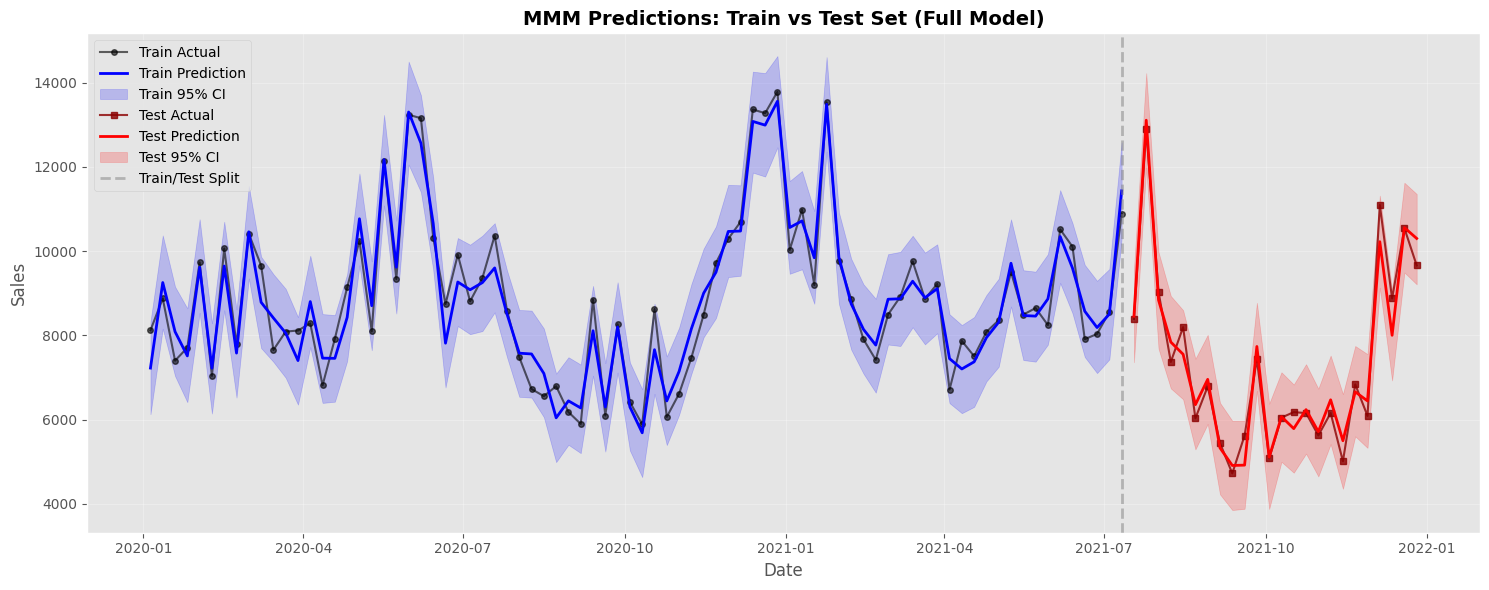

Prediction plot generated successfully!

In [31]:
import matplotlib.pyplot as plt


def plot_predictions(
    mmm: MMM,
    df_full: pl.DataFrame,
    df_train: pl.DataFrame,
    df_test: pl.DataFrame,
    X_full: pd.DataFrame
) -> None:
    """Plot model predictions vs actual values.

    The model was fitted on the full dataset, so we sample posterior predictive
    on the full dataset and then split it into train/test for visualization.

    Args:
        mmm: Fitted MMM model (trained on full dataset)
        df_full: Full dataframe with dates and actuals
        df_train: Training dataframe with dates and actuals
        df_test: Test dataframe with dates and actuals
        X_full: Full dataset features
    """
    rprint("\n[bold blue]Generating prediction plots...[/bold blue]")

    # Get target scale for manual rescaling
    target_scale = float(mmm.idata.constant_data["target_scale"].values)

    # Sample posterior predictive on FULL dataset (model was fitted on full data)
    mmm.sample_posterior_predictive(X_full, original_scale=True, extend_idata=True)
    full_pred = mmm.idata.posterior_predictive["y"].values * target_scale

    # Split predictions into train and test sets
    n_train = df_train.shape[0]
    train_pred = full_pred[:, :, :n_train]
    test_pred = full_pred[:, :, n_train:]

    # Compute mean and credible intervals
    train_pred_mean = train_pred.mean(axis=(0, 1))
    train_pred_lower = np.percentile(train_pred, 2.5, axis=(0, 1))
    train_pred_upper = np.percentile(train_pred, 97.5, axis=(0, 1))

    test_pred_mean = test_pred.mean(axis=(0, 1))
    test_pred_lower = np.percentile(test_pred, 2.5, axis=(0, 1))
    test_pred_upper = np.percentile(test_pred, 97.5, axis=(0, 1))

    # Get dates and actuals
    train_dates = df_train["date"].to_numpy()
    train_actuals = df_train["y"].to_numpy()
    test_dates = df_test["date"].to_numpy()
    test_actuals = df_test["y"].to_numpy()

    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))

    # Train set
    ax.plot(train_dates, train_actuals, 'o-', color='black', alpha=0.6, label='Train Actual', markersize=4)
    ax.plot(train_dates, train_pred_mean, '-', color='blue', label='Train Prediction', linewidth=2)
    ax.fill_between(train_dates, train_pred_lower, train_pred_upper, color='blue', alpha=0.2, label='Train 95% CI')

    # Test set
    ax.plot(test_dates, test_actuals, 's-', color='darkred', alpha=0.8, label='Test Actual', markersize=5)
    ax.plot(test_dates, test_pred_mean, '-', color='red', label='Test Prediction', linewidth=2)
    ax.fill_between(test_dates, test_pred_lower, test_pred_upper, color='red', alpha=0.2, label='Test 95% CI')

    # Vertical line separating train/test
    ax.axvline(train_dates[-1], color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Train/Test Split')

    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    ax.set_title('MMM Predictions: Train vs Test Set (Full Model)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    rprint("[bold green]Prediction plot generated successfully![/bold green]")


# Plot predictions (using full dataset since model was fitted on full data)
plot_predictions(
    mmm=final_mmm,
    df_full=df,
    df_train=df_train,
    df_test=df_test,
    X_full=X_full
)

## Compute ROAS and Compare with Ground Truth

In [ ]:
import json


def compute_and_compare_roas(
    model: MMM,
    channel_spend: pd.DataFrame,
    channel_columns: list[str],
    ground_truth_path: str | Path
) -> None:
    """Compute ROAS and compare with ground truth.
    
    Args:
        model: Fitted MMM model
        channel_spend: DataFrame with channel spend data
        channel_columns: List of channel column names
        ground_truth_path: Path to ground truth parameters JSON
    """
    # Compute channel contributions in ORIGINAL SCALE
    contributions = model.compute_mean_contributions_over_time(original_scale=True)
    
    # Compute ROAS: total contribution / total spend
    total_contributions = contributions[channel_columns].sum()
    total_spend = channel_spend[channel_columns].sum()
    roas = total_contributions / total_spend
    
    # Load ground truth
    with open(ground_truth_path) as f:
        ground_truth = json.load(f)
    
    true_roas = ground_truth["roas_values"]["Local"]
    
    # Create comparison table
    console = Console()
    table = Table(
        title="ROAS Comparison: Estimated vs Ground Truth",
        show_header=True,
        header_style="bold green"
    )
    
    table.add_column("Channel", style="cyan")
    table.add_column("Estimated ROAS", justify="right")
    table.add_column("True ROAS", justify="right")
    table.add_column("Error %", justify="right")
    
    for channel in channel_columns:
        # Extract base channel name
        channel_name = channel.split('_', 1)[1] if '_' in channel else channel
        
        est_val = roas[channel]
        true_val = true_roas.get(channel_name, 0.0)
        error_pct = ((est_val - true_val) / true_val * 100) if true_val != 0 else 0.0
        
        table.add_row(
            channel_name,
            f"{est_val:.2f}",
            f"{true_val:.2f}",
            f"{error_pct:+.1f}%"
        )
    
    console.print("\n")
    console.print(table)


# Compute and compare ROAS
ground_truth_path = Path("../data/mmm-simple/ground_truth_parameters.json")
compute_and_compare_roas(
    model=final_mmm,
    channel_spend=df_full_pandas,
    channel_columns=channel_columns,
    ground_truth_path=ground_truth_path
)

## Save Results

In [33]:
import json


def save_optimization_results(
    study: optuna.Study,
    evaluation_results: dict[str, float],
    output_dir: str | Path
) -> None:
    """Save optimization results to disk.
    
    Args:
        study: Completed Optuna study
        evaluation_results: Dictionary with train/test CRPS
        output_dir: Directory to save results
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save best parameters
    best_params_path = output_dir / "best_hyperparameters_crps.json"
    with open(best_params_path, "w") as f:
        json.dump(study.best_params, f, indent=2)
    
    # Save trials dataframe
    trials_df = study.trials_dataframe()
    trials_path = output_dir / "optimization_trials_crps.csv"
    trials_df.to_csv(trials_path, index=False)
    
    # Save evaluation results
    eval_path = output_dir / "final_evaluation_crps.json"
    with open(eval_path, "w") as f:
        json.dump(evaluation_results, f, indent=2)
    
    rprint(f"\n[bold green]Results saved to {output_dir}[/bold green]")
    rprint(f"  - Best parameters: {best_params_path}")
    rprint(f"  - Trial history: {trials_path}")
    rprint(f"  - Final evaluation: {eval_path}")


def save_final_model(model: MMM, output_path: str | Path) -> None:
    """Save final fitted model to disk.
    
    Args:
        model: Fitted MMM model
        output_path: Path to save model
    """
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    model.save(str(output_path))
    rprint(f"[bold green]Final model saved to {output_path}[/bold green]")


# Save results
save_optimization_results(
    study=study,
    evaluation_results=evaluation_results,
    output_dir=Path("../models/optimization_results")
)
save_final_model(final_mmm, output_path=Path("../models/mmm_optimized_crps.nc"))

Results saved to ../models/optimization_results

- Best parameters: ../models/optimization_results/best_hyperparameters_crps.json

- Trial history: ../models/optimization_results/optimization_trials_crps.csv

- Final evaluation: ../models/optimization_results/final_evaluation_crps.json

Final model saved to ../models/mmm_optimized_crps.nc

## Summary

This notebook demonstrated:

1. **Train/test split**: Chronological split with last 24 weeks as test set
2. **CRPS-based optimization**: Using test set performance instead of WAIC
3. **Hyperparameter search**: Optimizing `yearly_seasonality` and `adstock_max_lag`
4. **Convergence monitoring**: Strict checks on MCMC diagnostics
5. **Final model**: Refit on full dataset with optimal parameters
6. **Evaluation**: Train and test CRPS comparison
7. **Visualization**: Predictions vs actuals for both sets
8. **ROAS validation**: Comparison with known ground truth

### Key Differences from WAIC Approach

| Aspect | WAIC (Notebook 02) | CRPS (This Notebook) |
|--------|-------------------|----------------------|
| **Objective** | In-sample fit (penalized) | Out-of-sample prediction |
| **Data used** | Full training set | Held-out test set |
| **Evaluation** | Log predictive density | Proper scoring rule |
| **Advantage** | No data loss | Direct generalization metric |
| **Disadvantage** | Indirect measure | Less training data |

### Next Steps

- Compare optimal hyperparameters from WAIC vs CRPS approaches
- Implement k-fold time-series cross-validation
- Extend to optimize saturation function hyperparameters
- Add budget allocation optimization with optimal model